In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import os
import io
import warnings
import keras
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,Conv2D,Dropout,MaxPooling1D,Flatten
from unidecode import unidecode
import en_core_web_md
nlp = en_core_web_md.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

EDA

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train.shape

(7613, 5)

The missing values of the "keyword" column represent less than 1% of the dataset, it is kept.
We eliminate the "location" column to have too many missing values.

In [7]:
train = train[[col for col in train.columns if col != 'location']]
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We look at the unique values of the 'keyword' column.

In [8]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

We replace the "%20" with a space.

In [9]:
def replace20(x):
    
    try: 
        return x.replace('%20',' ')
    except AttributeError:
        return x

train['keyword'] = train['keyword'].apply(replace20)

train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train.groupby('keyword')['target'].mean().sort_values(ascending = False)

keyword
debris        1.000000
wreckage      1.000000
derailment    1.000000
outbreak      0.975000
oil spill     0.973684
                ...   
body bag      0.030303
blazing       0.029412
ruin          0.027027
body bags     0.024390
aftershock    0.000000
Name: target, Length: 221, dtype: float64

In [11]:
train["text"] = train["text"].apply(lambda x: str(x).lower())

In [12]:
train['is arobase']= train['text'].apply(lambda x:str(x).find('@') != -1).astype(int)

In [13]:
train['is arobase'].mean()

0.26783134112701956

In [14]:
print('If the tweet contains @, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is arobase')['target'].mean().loc[1],2))

print('If the tweet does not contain @, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is arobase')['target'].mean().loc[0],2))

If the tweet contains @, then the probability that it indicates a natural disaster is 0.33
If the tweet does not contain @, then the probability that it indicates a natural disaster is 0.47


In [15]:
train['is hashtag'] = train['text'].apply(lambda x:str(x).find('#') != -1).astype(int)

train['is hashtag'].mean()

0.2313148561670826

In [16]:
print('If the tweet contains #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[1],2))

print('If the tweet does not contain #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[0],2))

If the tweet contains #, then the probability that it indicates a natural disaster is 0.5
If the tweet does not contain #, then the probability that it indicates a natural disaster is 0.41


Pre-processing

In [17]:
train['text'] = train['text'].apply(unidecode)

We create a function that cleans the texts.

In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stops = set(stopwords.words('english'))
import spacy
sp = spacy.load('en_core_web_sm')

spacy_stopwords = sp.Defaults.stop_words

stops = stops.union(spacy_stopwords)

stops = stops.union({' ','.',',','',"i'm",'u','rt','http','like','//t','girl','girls',"'",'"','mkr'})

def remove_stop_words(words):

   return [word.lower() for word in words if word.lower() not in stops]  

import textcleaner as tc


def clean_text(text): 
    
  token_text = nlp(text)
    
  text = [element.lemma_.lower() for element in token_text]  

  clean_text = remove_stop_words(text)  
    
  text = " ".join(clean_text).strip().lower()  
  
  text = re.sub(r'[0-9]+','',text).strip()
  text = re.sub(r'[@]+','@',text).strip()
  text = re.sub(r'@','@ ', text).strip()  
  text = re.sub(r'[#]+','#',text).strip()
  text = re.sub(r'#','# ', text).strip() 
#  text = re.sub(r'\x[0-9]+','',text).strip()  
  text = re.sub(r'rt[\s]+','', text).strip()
  text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>_+=-]", "", text).strip()
  text = re.sub(r'http[A-Za-z0-9]+','', text).strip()
  text = re.sub(r'bbc','',text) .strip() 
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text).strip()   
  text = re.sub(r"i'm", "i am", text).strip()
  text = re.sub(r"he's", "he is", text).strip()
  text = re.sub(r"she's", "she is", text).strip()
  text = re.sub(r"that's", "that is", text).strip()        
  text = re.sub(r"what's", "what is", text).strip()
  text = re.sub(r"where's", "where is", text).strip() 
  text = re.sub(r"\'ll", " will", text).strip()  
  text = re.sub(r"\'ve", " have", text).strip()  
  text = re.sub(r"\'re", " are", text).strip()
  text = re.sub(r"\'d", " would", text).strip()
  text = re.sub(r"\'ve", " have", text).strip()
  text = re.sub(r"won't", "will not", text).strip()
  text = re.sub(r"don't", "do not", text).strip()
  text = re.sub(r"did't", "did not", text).strip()
  text = re.sub(r"can't", "can not", text).strip()
  text = re.sub(r"it's", "it is", text).strip()
  text = re.sub(r"couldn't", "could not", text).strip()
  text = re.sub(r"have't", "have not", text).strip()
  text = re.sub(r'[\s]+',' ',text)
    
  text = text.lower()   
    
#  text = remove_stop_words2(text).strip()

#  text = " ".join(text).strip()
 
  return text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [19]:
train['token_text'] = train['text'].apply(clean_text)

train['text_cleaned'] = train['token_text'].apply(lambda x : " ".join(x))
train

,id,keyword,text,target,is arobase,is hashtag,token_text,text_cleaned
0,1,NaN,our deeds are the reason of this #earthquake m...,1,0,1,"[deed, reason, #, earthquake, allah, forgive]",deed reason # earthquake allah forgive
1,4,NaN,forest fire near la ronge sask. canada,1,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,all residents asked to 'shelter in place' are ...,1,0,0,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0,1,"[people, receive, #, wildfire, evacuation, ord...",people receive # wildfire evacuation order cal...
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,0,1,"[got, send, photo, ruby, #, alaska, smoke, #, ...",got send photo ruby # alaska smoke # wildfire ...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,two giant cranes holding a bridge collapse int...,1,0,0,"[giant, crane, hold, bridge, collapse, nearby,...",giant crane hold bridge collapse nearby home
7609,10870,NaN,@aria_ahrary @thetawniest the out of control w...,1,1,0,"[@, ariaahrary, @, thetawni, control, wild, fi...",@ ariaahrary @ thetawni control wild fire cali...
7610,10871,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,0,0,"[m, [, utc], km, volcano, hawaii]",m [ utc] km volcano hawaii
7611,10872,NaN,police investigating after an e-bike collided ...,1,0,0,"[police, investigate, e, bike, collide, car, l...",police investigate e bike collide car little p...


In [20]:
def clean_keyword(x):
    
    try:
        clean_token = clean_text(x)
        return " ".join(clean_token)
    except ValueError:
        return ""

train['keyword_cleaned'] = train['keyword'].apply(clean_keyword)

In [21]:
train.iloc[:,[1,-1]].sample(16)

,keyword,keyword_cleaned
5058,natural disaster,natural disaster
1078,bomb,bomb
2525,desolation,desolation
6213,smoke,smoke
6965,tsunami,tsunami
1432,casualty,casualty
1563,cliff fall,cliff fall
1891,crushed,crush
370,army,army
6576,survivors,survivor


In [22]:
train['keyword_text_cleaned'] = train.keyword_cleaned + ' ' + train.text_cleaned

We look at the word clouds associated with each value of the target.

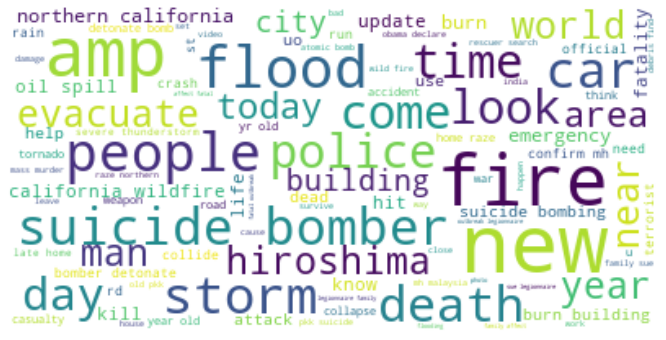

In [23]:
import matplotlib.pyplot as plt

text = " ".join(review for review in train[train['target'] == 1]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

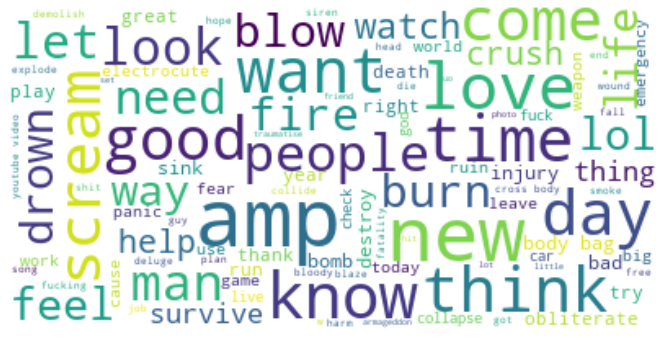

In [24]:
text = " ".join(review for review in train[train['target'] == 0]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
list_words_df3_label1 = []

for words in train[train['target'] == 1]['token_text'].tolist():
    list_words_df3_label1 += words

list_words_df3_label0 = []

for words in train[train['target'] == 0]['token_text'].tolist():
    list_words_df3_label0 += words

In [26]:
pd.DataFrame({'words':list_words_df3_label1}).value_counts().sort_values(ascending = False)[:10]

words     
#             1679
@              885
fire           268
kill           156
news           141
disaster       121
california     115
bomb           113
year           112
crash          112
dtype: int64

In [27]:
pd.DataFrame({'words':list_words_df3_label0}).value_counts().sort_values(ascending = False)[:10]

words
@        1827
#        1670
amp       193
new       172
good      120
body      119
love      117
come      108
time      106
video     103
dtype: int64

Train models

In [28]:
train['target'].mean()

0.4296597924602653

This is an unbalanced dataframe.

Model 1: with @ and #.

In [29]:
df = train.copy()

In [30]:
import numpy as np
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer1.fit_on_texts(df.keyword_text_cleaned)
df["text_encoded"] = tokenizer1.texts_to_sequences(df.text_cleaned)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))

In [31]:
df1 = df[df["len_text"]!=0]

text_pad1 = tf.keras.preprocessing.sequence.pad_sequences(df1.text_encoded, padding="post")

y = df1['target'].values

In [32]:
keyword_pad1 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer1.texts_to_sequences(df1.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad1 = np.concatenate([keyword_pad1,text_pad1],axis = 1)

In [33]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad1,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [34]:
X_train.shape

(4529, 17)

In [35]:
vocab_size = tokenizer1.num_words
model1 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],\
                                         name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  keras.layers.Dropout(0.2),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [36]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 conv1d (Conv1D)             (None, 17, 14)            5390      
                                                                 
 global_average_pooling1d (G  (None, 14)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

In [37]:
optimizer= keras.optimizers.Adam()

model1.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model1.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 3s 24ms/step - loss: 0.3803 - mean_absolute_error: 0.4902 - val_loss: 0.2970 - val_mean_absolute_error: 0.4805
Epoch 2/15
50/50 [==============================] - 1s 12ms/step - loss: 0.2617 - mean_absolute_error: 0.4740 - val_loss: 0.2341 - val_mean_absolute_error: 0.4512
Epoch 3/15
50/50 [==============================] - 1s 13ms/step - loss: 0.2136 - mean_absolute_error: 0.4309 - val_loss: 0.1915 - val_mean_absolute_error: 0.4038
Epoch 4/15
50/50 [==============================] - 1s 14ms/step - loss: 0.1797 - mean_absolute_error: 0.3731 - val_loss: 0.1695 - val_mean_absolute_error: 0.3467
Epoch 5/15
50/50 [==============================] - 1s 14ms/step - loss: 0.1541 - mean_absolute_error: 0.3212 - val_loss: 0.1628 - val_mean_absolute_error: 0.3342
Epoch 6/15
50/50 [==============================] - 1s 14ms/step - loss: 0.1518 - mean_absolute_error: 0.3141 - val_loss: 0.1589 - val_mean_absolute_error: 0.3195
Epoch 7/15
50/50 [====

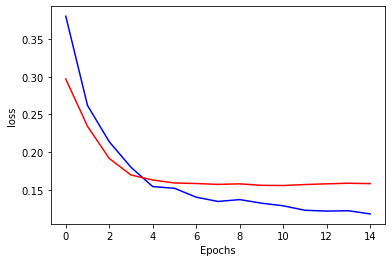

In [38]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [39]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

48/48 [==============================] - 0s 4ms/step


In [40]:
np.array(y_train).mean()

0.4318834179730625

In [41]:
np.array(y_val).mean()

0.43178807947019865

In [42]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8719364098034886
accuracy score test : 0.7993377483443709
f1 score train : 0.8432432432432432
f1 score test : 0.7534580960130188


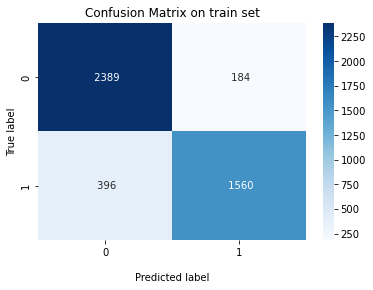

In [43]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

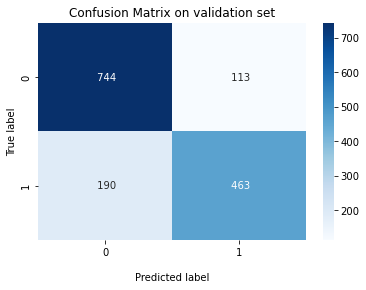

In [44]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on validation set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [45]:
df1['pred prob target'] = model1.predict(text_pad1)
df1['pred target'] = df1['pred prob target'].apply(lambda x : x>0.5)

236/236 [==============================] - 1s 3ms/step


In [46]:
size = ((df1.target == 1)&(df1['pred target'] == 0)).sum()

idx = np.random.randint(size)

df1[(df1.target == 1)&(df1['pred target'] == 0)].iloc[idx]['text']

'illinois tornado slipped under the radar emergency officials say http://t.co/zhgu8ye1bj'

Model2: same model than model1 but we eliminate @ and #.

In [78]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer2.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer2.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df2 = df_bis[df_bis["len_text"]!=0]

text_pad2 = tf.keras.preprocessing.sequence.pad_sequences(df2.text_encoded, padding="post")

y = df2['target'].values

keyword_pad2 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer2.texts_to_sequences(df2.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad2 = np.concatenate([keyword_pad2,text_pad2],axis = 1)

In [79]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad2,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [80]:
vocab_size = tokenizer2.num_words
model2 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = None # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [81]:
optimizer= keras.optimizers.Adam()

model2.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model2.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=6, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/6
50/50 [==============================] - 1s 11ms/step - loss: 0.2396 - mean_absolute_error: 0.4839 - val_loss: 0.2260 - val_mean_absolute_error: 0.4682
Epoch 2/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1894 - mean_absolute_error: 0.4146 - val_loss: 0.1719 - val_mean_absolute_error: 0.3818
Epoch 3/6
50/50 [==============================] - 0s 9ms/step - loss: 0.1467 - mean_absolute_error: 0.3291 - val_loss: 0.1567 - val_mean_absolute_error: 0.3295
Epoch 4/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1244 - mean_absolute_error: 0.2728 - val_loss: 0.1542 - val_mean_absolute_error: 0.2934
Epoch 5/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1221 - mean_absolute_error: 0.2589 - val_loss: 0.1570 - val_mean_absolute_error: 0.3013
Epoch 6/6
50/50 [==============================] - 0s 7ms/step - loss: 0.1115 - mean_absolute_error: 0.2390 - val_loss: 0.1589 - val_mean_absolute_error: 0.2775


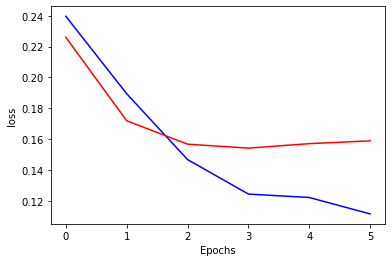

In [82]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [83]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [84]:
print('accuracy score train :', accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :', accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' ,  f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.864650033119894
accuracy score test : 0.7933774834437086
f1 score train : 0.827080394922426
f1 score test : 0.74


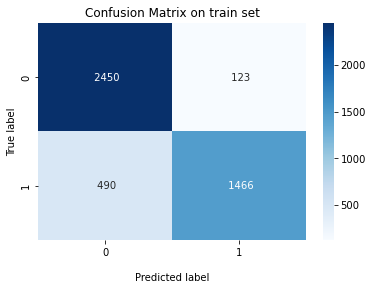

In [85]:
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

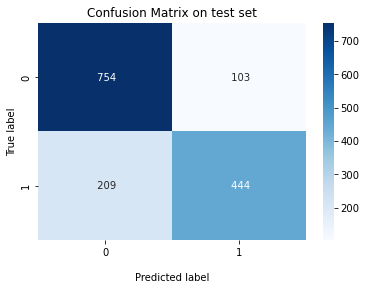

In [87]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on test set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

The results are good. We now test a new model where we use Long short-term memory. 

Model3

In [54]:
tokenizer3 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer3.fit_on_texts(df.keyword_text_cleaned)

df3 = df.copy()

tweet_pads3 = tokenizer3.texts_to_sequences(df3.text_cleaned)

In [55]:
tweet_pads3 = tf.keras.preprocessing.sequence.pad_sequences(tweet_pads3, padding="post")

In [56]:
keyword_pads3 = tokenizer3.texts_to_sequences(df3.keyword_cleaned.tolist())

In [57]:
keyword_pads3 = tf.keras.preprocessing.sequence.pad_sequences(keyword_pads3, padding="post")

In [58]:
keyword_tweet_pads3 = np.concatenate([keyword_pads3,tweet_pads3],axis = 1)

In [59]:
y = df3['target']

In [60]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_tweet_pads3,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [61]:
X_test.shape

(1523, 17)

In [62]:
model3 = keras.models.Sequential()

model3.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model3.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model3.add(keras.layers.Dropout(0.2))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [63]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional (Bidirectiona  (None, 30)               17280     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                1984      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                      

In [64]:
optimizer= keras.optimizers.Adam()

model3.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [65]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=8, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/8
50/50 [==============================] - 11s 48ms/step - loss: 0.3477 - mean_absolute_error: 0.4793 - val_loss: 0.2985 - val_mean_absolute_error: 0.4340
Epoch 2/8
50/50 [==============================] - 1s 18ms/step - loss: 0.2358 - mean_absolute_error: 0.3498 - val_loss: 0.2036 - val_mean_absolute_error: 0.2832
Epoch 3/8
50/50 [==============================] - 1s 30ms/step - loss: 0.1828 - mean_absolute_error: 0.2898 - val_loss: 0.1855 - val_mean_absolute_error: 0.2976
Epoch 4/8
50/50 [==============================] - 1s 23ms/step - loss: 0.1546 - mean_absolute_error: 0.2517 - val_loss: 0.1744 - val_mean_absolute_error: 0.2852
Epoch 5/8
50/50 [==============================] - 1s 25ms/step - loss: 0.1387 - mean_absolute_error: 0.2391 - val_loss: 0.1737 - val_mean_absolute_error: 0.2695
Epoch 6/8
50/50 [==============================] - 2s 31ms/step - loss: 0.1314 - mean_absolute_error: 0.2367 - val_loss: 0.1725 - val_mean_absolute_error: 0.2605
Epoch 7/8
50/50 [==========

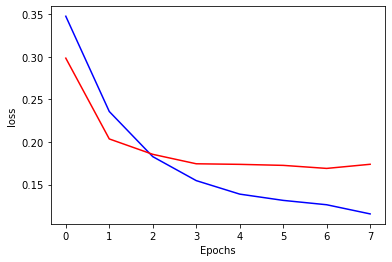

In [66]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [67]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 6ms/step
accuracy score train : 0.8916137508211079
accuracy score test : 0.7774130006565988
f1 score train :  0.8655986967146349
f1 score test :  0.723265306122449


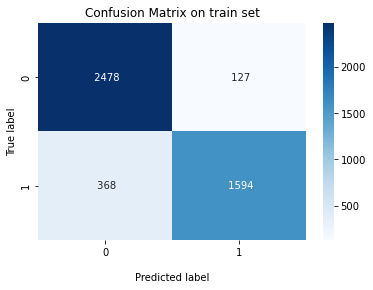

In [68]:
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

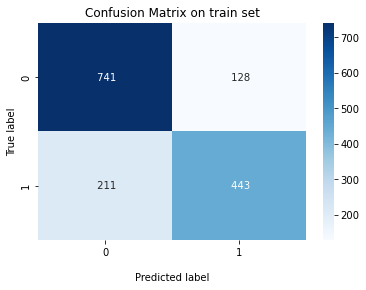

In [69]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

Results are not better than model2. We now removing @ and #.

In [70]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer4 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer4.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer4.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df4 = df_bis[df_bis["len_text"]!=0]

text_pad4 = tf.keras.preprocessing.sequence.pad_sequences(df4.text_encoded, padding="post")

y = df4['target'].values

keyword_pad4 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer4.texts_to_sequences(df4.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad4 = np.concatenate([keyword_pad4,text_pad4],axis = 1)

In [71]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad4,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [72]:
model4 = keras.models.Sequential()

model4.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model4.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model4.add(keras.layers.Dropout(0.2))

model4.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(X_train.shape[1],)))

model4.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model4.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [73]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               17280     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                1984      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                      

In [74]:
optimizer= keras.optimizers.Adam()

model4.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [75]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 12s 76ms/step - loss: 0.1383 - mean_absolute_error: 0.2524 - val_loss: 0.1345 - val_mean_absolute_error: 0.2315
Epoch 2/15
50/50 [==============================] - 1s 24ms/step - loss: 0.1341 - mean_absolute_error: 0.2526 - val_loss: 0.1352 - val_mean_absolute_error: 0.2309
Epoch 3/15
50/50 [==============================] - 1s 26ms/step - loss: 0.1293 - mean_absolute_error: 0.2436 - val_loss: 0.1356 - val_mean_absolute_error: 0.2487
Epoch 4/15
50/50 [==============================] - 2s 39ms/step - loss: 0.1172 - mean_absolute_error: 0.2204 - val_loss: 0.1394 - val_mean_absolute_error: 0.2539
Epoch 5/15
50/50 [==============================] - 2s 32ms/step - loss: 0.1195 - mean_absolute_error: 0.2243 - val_loss: 0.1473 - val_mean_absolute_error: 0.2562
Epoch 6/15
50/50 [==============================] - 1s 27ms/step - loss: 0.1138 - mean_absolute_error: 0.2223 - val_loss: 0.1471 - val_mean_absolute_error: 0.2550
Epoch 7/15
50/50 [===

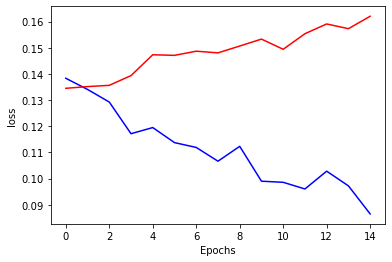

In [76]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [77]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 1s 9ms/step
accuracy score train : 0.4449105762861559
accuracy score test : 0.452317880794702
f1 score train :  0.5754812563323201
f1 score test :  0.58379466532461


These results are very bad. We finally use model1 in order to make prediction on the file test.csv.

In [93]:
sample = pd.read_csv('sample_submission.csv',index_col = 0)

In [94]:
test = pd.read_csv('test.csv')

In [95]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [96]:
test['keyword'] = test['keyword'].apply(replace20)

In [97]:
test['text_cleaned']=test['text'].apply(clean_text).apply(lambda x : " ".join(x))
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear # earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting # spokane # wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [98]:
test['keyword_cleaned'] = test['keyword'].apply(clean_keyword)
test.sample(15)

,id,keyword,location,text,text_cleaned,keyword_cleaned
2888,9558,thunder,phx az,The most prescient part of Tropic Thunder was ...,prescient tropic thunder fat suit facomedy use...,thunder
679,2202,catastrophic,www.facebook.com/Randirobics,Society will collapse by 2040 due to catastrop...,society collapse catastrophic food shortage study,catastrophic
1626,5472,flames,NaN,@xodeemorgss she went to get rice and the whol...,@ xodeemorgss rice thing tip flame pant omg sorry,flame
2377,7947,rainstorm,"Calgary, Alberta",@WerdEmUp It's already been messed up thanks t...,@ werdemup mess thank early rainstorm need mai...,rainstorm
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,check # nsfw,ablaze
1467,4865,explode,~always in motion~,Vanessa was about to explode! This is what she...,vanessa explode want shelli alliance survive #...,explode
2537,8467,screamed,earth,' #OTRAMETLIFE ' I SWEAR TO GOD I DIDNT EVEN R...,# otrametlife swear god didnt read properly om...,scream
1955,6592,inundated,"Shrewsbury, England",@Ryanair I am waiting to hear about my claim f...,@ ryanair wait hear claim compensation receive...,inundate
1347,4443,electrocute,Bieber Fever UK,Why can't robots have a shower? \nAnswer: Beca...,robot shower answer electrocute,electrocute
1992,6715,lava,"New York, NY",Watch Steaks Being Grilled Over Molten Hot Lav...,watch steaks grill molten hot lava,lava


In [99]:
test['keyword_cleaned'].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleeding', 'blow',
       'blight', 'blizzard', 'blood', 'bloody', 'body bag',
       'body bagging', 'bomb', 'bombing', 'bridge collapse',
       'building burn', 'building fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust storm', 'earthquake', 'electrocute',

In [ ]:
Tous les mots clefs sont composés de deux mots.

In [ ]:
text_encoded = tokenizer1.texts_to_sequences(test.text_cleaned)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_encoded, padding="post")
text_pad[:5,:]

In [ ]:
text_pad.shape

In [ ]:
keywords_encoded = tokenizer2.texts_to_sequences(test.keyword_cleaned)
keyword_pad = tf.keras.preprocessing.sequence.pad_sequences(keywords_encoded, padding="post")
keyword_pad.shape

In [ ]:
keyword_text_pad = np.concatenate([keyword_pad,text_pad],axis = 1)
keyword_text_pad.shape

In [ ]:
sample['target']=(model2.predict(keyword_text_pad)>0.5).astype(int)

In [ ]:
sample.head()

In [ ]:
predict1 = sample[sample.target == 1].index
predict0 = sample[sample.target == 0].index

In [ ]:
idx = np.random.randint(len(predict1))

test.loc[predict1].iloc[idx]['text']

In [ ]:
idx = np.random.randint(len(predict0))

test.loc[predict0].iloc[idx]['text']

In [ ]:
sample.to_csv('sample_submission.csv')